In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define your data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define a custom dataset for CheXpert
class CheXpertDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        
        # Load the csv file that contains the image paths and labels
        self.data = pd.read_csv(csv_file)
        
        # Replace the uncertain labels (-1) with NaN
        self.data = self.data.replace(-1, np.nan)
        
        # Convert the DataFrame to a dictionary for easy access
        self.data_dict = self.data.to_dict('index')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label for the given index
        img_path = os.path.join(self.root_dir, self.data_dict[idx]['Path'])
        label = self.data_dict[idx]
        
        # Load the image and apply the transform
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
        # Convert the label to a tensor and remove the 'Path' key
        label = {k: v for k, v in label.items() if k != 'Path'}
        label = torch.tensor(list(label.values())).float()
        
        # Return the image and label
        return img, label

# Define the paths to the training and validation csv files
train_csv = '/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv'
val_csv = '/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv'

# Load the data
BATCH_SIZE = 32
train_dataset = CheXpertDataset('/kaggle/input/chexpert/CheXpert-v1.0-small/train', train_csv, transform=transform_train)
val_dataset = CheXpertDataset('/kaggle/input/chexpert/CheXpert-v1.0-small/valid', val_csv, transform=transform_test, mode='val')



In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [2]:
train_loader.shape

NameError: name 'train_loader' is not defined

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

NameError: name 'Image' is not defined

In [4]:
import os
import cv2
import warnings
import datetime
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix, multilabel_confusion_matrix, hamming_loss, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

from keras import backend as K
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.applications.xception import Xception
from keras.applications.efficientnet_v2 import EfficientNetV2B2
from keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
import shutil
import seaborn as sns
sns.axes_style(style={'xtick.top':True})

print(tf.__version__)
!nvidia-smi

2.11.0
Wed Mar  1 17:51:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
|

In [6]:
model_path='.'
path='/kaggle/input/chexpert/CheXpert-v1.0-small'
train_folder=f'{path}train'
test_folder=f'{path}valid'
train_lbl=f'{path}train.csv'
data_path = Path(path)
train_df = pd.read_csv(data_path/'train.csv')
test_df = pd.read_csv(data_path/'valid.csv')

In [8]:
features = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
            'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
            'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
            'Pleural Other', 'Fracture', 'Support Devices']
chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 25)

In [9]:
def make_diagnosis(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)

    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)

    return ';'.join(feature_list)

In [10]:
print("Frontal - Lateral view image count: "  )
print(train_df['Frontal/Lateral'].value_counts())
train_df.drop(train_df[train_df['Frontal/Lateral']=='Lateral'].index, inplace=True)
train_df = train_df.reset_index(drop=True)
print("Frontal - Lateral view image count: "  )
print(test_df['Frontal/Lateral'].value_counts())
test_df.drop(test_df[test_df['Frontal/Lateral']=='Lateral'].index, inplace=True)
test_df = test_df.reset_index(drop=True)

Frontal - Lateral view image count: 
Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64
Frontal - Lateral view image count: 
Frontal    202
Lateral     32
Name: Frontal/Lateral, dtype: int64


In [11]:
train_df['Diagnosis'] = train_df.apply(make_diagnosis,axis = 1).fillna('')
train_df['Diagnosis'] = train_df['Diagnosis'].apply(lambda x:x.split(";"))
train_df.head()
test_df['Diagnosis'] = test_df.apply(make_diagnosis,axis = 1).fillna('')
test_df['Diagnosis'] = test_df['Diagnosis'].apply(lambda x:x.split(";"))
test_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Diagnosis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Cardiomegaly]
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,[]
2,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Edema]
3,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[]
4,CheXpert-v1.0-small/valid/patient64545/study1/...,Female,55,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,"[Atelectasis, Pleural Effusion]"


In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                 featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=5,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 validation_split = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
type(train_datagen)

keras.preprocessing.image.ImageDataGenerator

In [23]:
my_path = '/kaggle/input/chexpert/CheXpert-v1.0-small/train'

In [24]:
def generate_datasets(image_size = 224):

    train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=my_path,
                                                x_col="Path", y_col="Diagnosis", has_ext=True, shuffle=False, classes = chexpert_targets,
                                                class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "training")

    validation_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=data_path,
                                                       x_col="Path", y_col="Diagnosis", has_ext=True, shuffle=False, classes = chexpert_targets,
                                                       class_mode="categorical", target_size=(image_size,image_size), batch_size=32, subset = "validation")

    test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=data_path,
                                                      x_col="Path", y_col="Diagnosis",
                                                      target_size=(image_size,image_size),class_mode='categorical',
                                                      batch_size=1, shuffle=False)

    return [train_generator,validation_generator,test_generator]

In [25]:
image_size_input = 224
datasets = generate_datasets(image_size = image_size_input)
train_generator, validation_generator, test_generator = datasets

Found 0 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 0 classes.


In [28]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow as tf
import tensorflow.keras
import keras.backend as K

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from glob import glob
from PIL import Image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
# import os

In [46]:
my_glob = glob('/kaggle/input/chexpert/CheXpert-v1.0-small/train/patient*/study*/*.jpg')
print('Number of Observations: ', len(my_glob)) 

Number of Observations:  223414


In [47]:
train_df = pd.read_csv('/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv')
print(f'the shape of the training dataset is : {train_df.shape}')
train_df.head()

the shape of the training dataset is : (223414, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [48]:
train_df['Path'] = '/kaggle/input/chexpert/' + train_df['Path'].astype(str)

In [49]:
# 'CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg'
train_df['Path'][0] 


'/kaggle/input/chexpert/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'

In [50]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [51]:
def prepare_dataset(dataframe,policy,class_names):
    dataset_df = dataframe[dataframe['Frontal/Lateral'] == 'Frontal'] #take frontal pics only
    df = dataset_df.sample(frac=1., random_state=1)
    df.fillna(0, inplace=True) #fill the with zeros
    x_path, y_df = df["Path"].to_numpy(), df[class_names]
    class_ones = ['Atelectasis', 'Cardiomegaly']
    y = np.empty(y_df.shape, dtype=int)
    for i, (index, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            feat_val = 0
            if curr_val:
                curr_val = float(curr_val)
                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    if policy == "ones":
                        feat_val = 1
                    elif policy == "zeroes":
                        feat_val = 0
                    elif policy == "mixed":
                        if cls in class_ones:
                            feat_val = 1
                        else:
                            feat_val = 0
                    else:
                        feat_val = 0
                else:
                    feat_val = 0
            else:
                feat_val = 0
            
            labels.append(feat_val)
            
        y[i] = labels
        
    return x_path,y

In [52]:
class_names = ['Atelectasis', 'Pneumothorax', 'Consolidation', 'Edema', 'Pleural Effusion']
policy = ['ones','zeroes','mixed']
x_path,labels = prepare_dataset(train_df,policy[-1],class_names)

In [53]:
train_df = pd.DataFrame({'path':x_path})
df2 = pd.DataFrame(labels,columns=class_names)
train_df[list(df2.columns)]=df2 

Pleural Effusion    76899
Atelectasis         59583
Edema               49675
Pneumothorax        17693
Consolidation       12983
dtype: int64


(<AxesSubplot:ylabel='0'>,
 (array([0, 1, 2, 3, 4]),
  [Text(0, 0, 'Pleural Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Pneumothorax'),
   Text(4, 0, 'Consolidation')]))

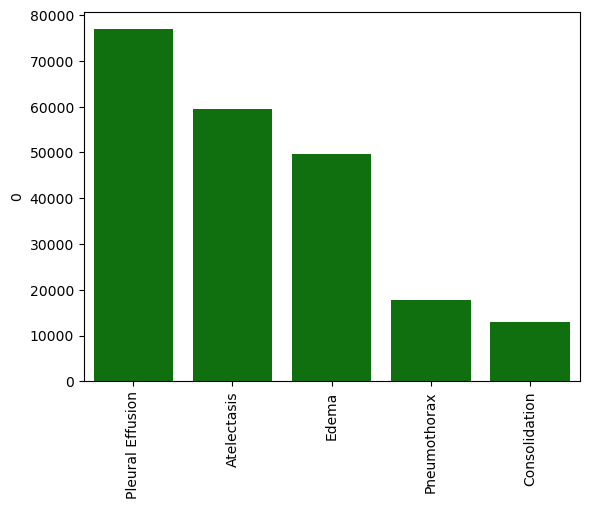

In [54]:
clean_labels = train_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [55]:
valid_df = pd.read_csv('/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv')
print(f'the shape of the validation dataset is : {valid_df.shape}')
valid_df.head()

the shape of the validation dataset is : (234, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
valid_df['Path'] = '/kaggle/input/chexpert/' + valid_df['Path'].astype(str)
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
my_glob_valid = glob('/kaggle/input/chexpert/CheXpert-v1.0-small/valid/patient*/study*/*.jpg')
print('Number of Observations: ', len(my_glob_valid)) 

Number of Observations:  234


In [59]:
valid_x_path,valid_labels = prepare_dataset(valid_df,policy[-1],class_names)

In [60]:
valid_df = pd.DataFrame({'path':valid_x_path})
df2_valid = pd.DataFrame(valid_labels,columns=class_names)
valid_df[list(df2.columns)]=df2_valid

In [61]:
IMG_SIZE = (224,224)
CHANNELS = 3

In [64]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           shear_range=0.2,
                                                           zoom_range=0.2,
                                                           rotation_range=20,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           horizontal_flip=True)

train_gen = base_gen.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle=True,
                                         # color_mode = 'grayscale',
                                         batch_size=16)

valid_gen = base_gen.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle = True,
                                         # color_mode = 'grayscale',
                                         batch_size=16)  # we can use much larger batches for evaluation


test_X, test_Y = next(base_gen.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col=class_names,
                                                   class_mode='raw',
                                                   target_size=IMG_SIZE,
                                                   shuffle = True,
                                                   # color_mode = 'grayscale',
                                                   batch_size=16))

Found 191027 validated image filenames.
Found 202 validated image filenames.
Found 202 validated image filenames.


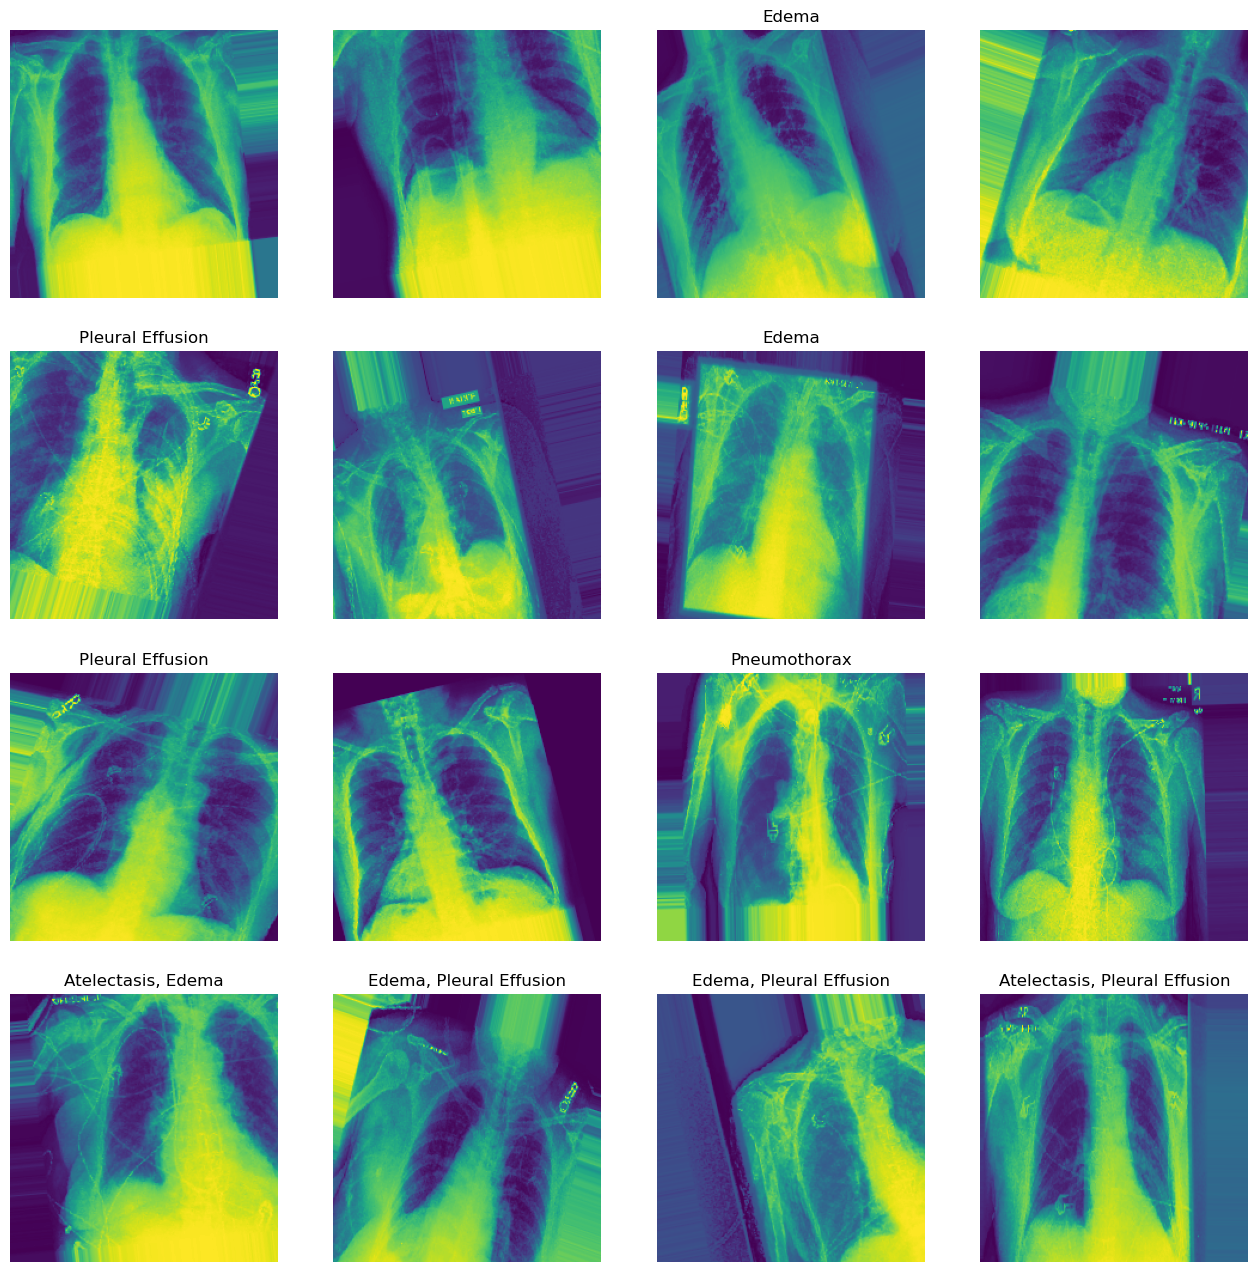

In [65]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [66]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [67]:
trdata = train_gen #ImageDataGenerator()
# traindata = trdata.flow_from_directory(directory="data",target_size=(224,224))
tsdata = valid_gen #ImageDataGenerator()
# testdata = tsdata.flow_from_directory(directory="test", target_size=(224,224))

In [93]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=5, activation="sigmoid"))

In [94]:
from keras.optimizers import Adam
opt = Adam(lr=0.0003)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_53 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_55 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [96]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=100,generator=train_gen, validation_data= valid_gen, validation_steps=10,epochs=10,callbacks=[average_acc_checkpoint,early])

Epoch 1/10
100/100 [==============================] - 49s 475ms/step - loss: 2.1827 - accuracy: 0.2438 - val_loss: 6.8701 - val_accuracy: 0.0688
Epoch 2/10
100/100 [==============================] - 44s 441ms/step - loss: 1386872.0000 - accuracy: 0.2519 - val_loss: 66390464.0000 - val_accuracy: 0.8000
Epoch 3/10
100/100 [==============================] - 45s 443ms/step - loss: 5337464700928.0000 - accuracy: 0.2525 - val_loss: 26882550530048.0000 - val_accuracy: 0.1000
Epoch 4/10
100/100 [==============================] - 44s 441ms/step - loss: 3618147559014400.0000 - accuracy: 0.2456 - val_loss: 80524469226962944.0000 - val_accuracy: 0.7875
Epoch 5/10
100/100 [==============================] - 44s 440ms/step - loss: nan - accuracy: 0.4406 - val_loss: nan - val_accuracy: 0.7937
Epoch 6/10
 74/100 [=====================>........] - ETA: 10s - loss: nan - accuracy: 0.5895

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.callbacks import Callback

class AverageAccuracyCheckpoint(Callback):
    def _init_(self, filepath):
        super()._init_()
        self.filepath = filepath
        self.filepath2 = filepath2


    def on_epoch_end(self, epoch, logs):
        self.model.save(self.filepath)
        self.model.save(self.filepath)
        print('saved==============')
        
filepath = "/kaggle/working/vgg16_1.hdf5"
filepath2 = "/kaggle/working/vgg16_1.h5"
average_acc_checkpoint = AverageAccuracyCheckpoint(filepath, filepath2)

In [103]:
# Assuming that you have trained and compiled your model
# and saved the weights using ModelCheckpoint callback
from keras.models import load_model

# Load the model
next_model = load_model('/kaggle/working/vgg16_1.h5')

# Save the model to a file
# model.save('vgg16_1.h5')


In [104]:
next_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
from keras.preprocessing import image
img = image.load_img("image.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("/kaggle/working/vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')